# 9. Mély számítógépes látás
## Könyvtárak

In [3]:
import os
import torch
import random
import zipfile
import tarfile
import requests
import torchvision
import numpy as np  # dependency: numpy==1.23.5 # pip install numpy==1.23.5
import matplotlib.pyplot as plt
from torchvision import transforms
import torchvision.transforms.functional as F
import torchvision.models.detection as detection
from torchvision.datasets import VOCSegmentation
from torchvision.models.detection import MaskRCNN_ResNet50_FPN_Weights

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

## Adathalmaz
PASCAL VOC adathalmaz. A letöltésben a validációs halmaz fog letöltődni a kisebb mérete miatt. Tanítás esetén érdemes a tanító, validáció és teszt adatokat külön letölteni. 

In [8]:
class Transform:
    def __call__(self, img, target):
        return transforms.ToTensor()(img), transforms.ToTensor()(target)

transform = Transform()

# Download and load the Pascal VOC dataset
dataset = VOCSegmentation(root='./data', year='2012', image_set='val', download=True, transforms=transform)

# Véletlen részhalmaz kiválasztása az adathalmazból
random.seed(0)
n_images = 200
random_indices = random.sample(range(len(dataset)), n_images)
subset = torch.utils.data.Subset(dataset, random_indices)

Using downloaded and verified file: ./data/VOCtrainval_11-May-2012.tar
Extracting ./data/VOCtrainval_11-May-2012.tar to ./data


## Modell

In [9]:
# Load a pre-trained Mask R-CNN model
model = detection.maskrcnn_resnet50_fpn(weights=MaskRCNN_ResNet50_FPN_Weights.COCO_V1)

# Move model to the compute device
model.to(device)

# Put the model in evaluation mode
model.eval()

MaskRCNN(
  (transform): GeneralizedRCNNTransform(
      Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
      Resize(min_size=(800,), max_size=1333, mode='bilinear')
  )
  (backbone): BackboneWithFPN(
    (body): IntermediateLayerGetter(
      (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
      (bn1): FrozenBatchNorm2d(64, eps=0.0)
      (relu): ReLU(inplace=True)
      (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (layer1): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): FrozenBatchNorm2d(64, eps=0.0)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): FrozenBatchNorm2d(64, eps=0.0)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): FrozenBatchNorm2d(256, eps=0.0)
          (relu): ReLU(in

## Predikció az adathalmazon

In [10]:
predictions = []

for img, target in subset:
    with torch.no_grad():
        prediction = model([img.to(device)])
    predictions.append({'prediction': prediction, 'target': target, 'image': img})

## Kiértékelés
### Maszkok összefésülésére függvény

In [11]:
def merge_masks(masks, cap = True):
    result = np.zeros((masks.shape[2], masks.shape[3]))
    for i in range(masks.shape[0]):
        mask = masks[i, 0, :, :]
        binary_mask = mask > 0.5
        if cap:
            result[binary_mask] = 1
        else:
            result[binary_mask] = mask[binary_mask]
    return result

### IoU kiszámítása egy képpárra

In [12]:
def calculate_iou(prediction, target):
    prediction = np.array(prediction)
    target = np.array(target)
    
    target[target > 0] = 1 
    prediction = prediction.astype(int)
    target = target.astype(int)

    # Flatten the tensors to simplify calculation
    prediction_flat = prediction.reshape(-1)
    target_flat = target.reshape(-1)

    # Calculate intersection and union
    intersection = (prediction_flat * target_flat).sum()
    union = prediction_flat.sum() + target_flat.sum() - intersection

    # Compute the IoU
    iou = (intersection + 1e-6) / (union + 1e-6)  # Adding a small value to avoid division by zero
    return iou.item()

### IoU kiszámítása minden képre

In [13]:
ious = []

for entry in predictions:
    target_masks = entry['target'][0]
    pred_masks = entry['prediction'][0]['masks']
    pred_masks_merged = merge_masks(pred_masks)

    iou = calculate_iou(pred_masks_merged, target_masks)
    ious.append(iou)

# Calculate the average IoU across all images
average_iou = sum(ious) / len(ious)
print(f"Átlagos IoU: {round(average_iou * 100, 2)}%")

Átlagos IoU: 67.46%


## Eredmények ábrázolása
### Eredeti kép, valós maszk és becsült maszk

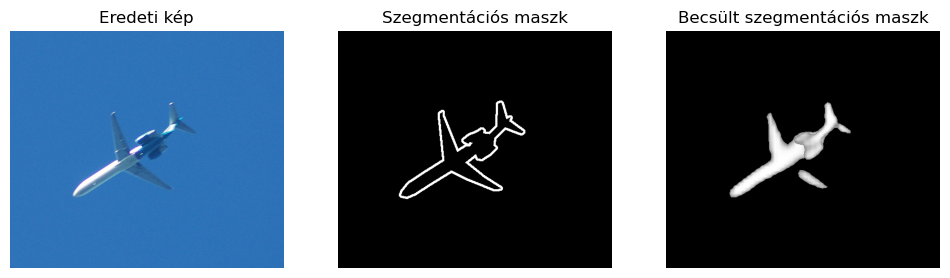

In [14]:
idx = 5  # Itt lehet kép ID-t választani 
threshold = 0.5

# Extract the first image and mask from the predictions
image = predictions[idx]['image']
mask = merge_masks(predictions[idx]['prediction'][0]['masks'], cap=False)

fig, ax = plt.subplots(1, 3, figsize=(12, 6))  # Create a figure with two subplots

# Display the original image
ax[0].imshow(image.permute(1, 2, 0))
ax[0].set_title("Eredeti kép")
ax[0].axis('off')  # Turn off axis numbers and labels

ax[1].imshow(predictions[idx]['target'][0, :, :].numpy(), cmap='gray')
ax[1].set_title("Szegmentációs maszk")
ax[1].axis('off')  # Turn off axis numbers and labels

# Display the binary mask
ax[2].imshow(mask, cmap='gray')
ax[2].set_title("Becsült szegmentációs maszk")
ax[2].axis('off')  # Turn off axis numbers and labels

plt.show()

---
# Panoptikus szegmentáció: OneFormer
OneFormer Git tárhely: https://github.com/SHI-Labs/OneFormer/tree/main  
  
OneFormer telepítése, konfigok és demo: https://github.com/SHI-Labs/OneFormer/blob/main/colab/oneformer_colab.ipynb

In [2]:
import os 
import cv2 
import sys
import imutils
import warnings

# Setup detectron2 logger
import detectron2
from detectron2.utils.logger import setup_logger

# Configs
setup_logger()
setup_logger(name="oneformer")
sys.path.append('./oneformer/')
warnings.filterwarnings('ignore')
parent_dir = os.path.join(os.path.dirname(os.path.abspath('__file__')), '..')
sys.path.append(parent_dir)

# Setup detectron2 logger
from detectron2 import model_zoo
from detectron2.config import get_cfg
from detectron2.data import MetadataCatalog
from detectron2.modeling import build_model
from detectron2.checkpoint import DetectionCheckpointer
from detectron2.projects.deeplab import add_deeplab_config
from detectron2.utils.visualizer import ColorMode as DetectronColorMode
from detectron2.utils.visualizer import Visualizer as DetectronVisualizer 
from detectron2.engine import DefaultPredictor as DetectronDefaultPredictor

# Import OneFormer Project
from demo.defaults import DefaultPredictor
from oneformer.config import add_swin_config
from oneformer.config import add_dinat_config
from oneformer.config import add_common_config
from oneformer.config import add_convnext_config
from oneformer.config import add_oneformer_config
from demo.visualizer import Visualizer, ColorMode


## Modell betöltése

In [3]:
%%capture
cpu_device = torch.device("cpu")
SWIN_CFG_DICT = {"cityscapes": "./oneformer/configs/cityscapes/oneformer_swin_large_IN21k_384_bs16_90k.yaml",
            "coco": "./oneformer/configs/coco/oneformer_swin_large_IN21k_384_bs16_100ep.yaml",
            "ade20k": "./oneformer/configs/ade20k/oneformer_swin_large_IN21k_384_bs16_160k.yaml",}

DINAT_CFG_DICT = {"cityscapes": "./oneformer/configs/cityscapes/oneformer_dinat_large_bs16_90k.yaml",
            "coco": "./oneformer/configs/coco/oneformer_dinat_large_bs16_100ep.yaml",
            "ade20k": "./oneformer/configs/ade20k/oneformer_dinat_large_IN21k_384_bs16_160k.yaml",}

def setup_cfg(dataset, model_path, use_swin):
    # load config from file and command-line arguments
    cfg = get_cfg()
    add_deeplab_config(cfg)
    add_common_config(cfg)
    add_swin_config(cfg)
    add_dinat_config(cfg)
    add_convnext_config(cfg)
    add_oneformer_config(cfg)
    if use_swin:
      cfg_path = SWIN_CFG_DICT[dataset]
    else:
      cfg_path = DINAT_CFG_DICT[dataset]
    cfg.merge_from_file(cfg_path)
    cfg.MODEL.DEVICE = 'cpu'
    cfg.MODEL.WEIGHTS = model_path
    cfg.freeze()
    return cfg

def setup_modules(dataset, model_path, use_swin):
    cfg = setup_cfg(dataset, model_path, use_swin)
    predictor = DefaultPredictor(cfg)
    metadata = MetadataCatalog.get(
        cfg.DATASETS.TEST_PANOPTIC[0] if len(cfg.DATASETS.TEST_PANOPTIC) else "__unused"
    )
    if 'cityscapes_fine_sem_seg_val' in cfg.DATASETS.TEST_PANOPTIC[0]:
        from cityscapesscripts.helpers.labels import labels
        stuff_colors = [k.color for k in labels if k.trainId != 255]
        metadata = metadata.set(stuff_colors=stuff_colors)

    return predictor, metadata

# Setup 
use_swin = True  # We use `DiNAT-L` as the default backbone. To use Swin-L as backbone, select the checkboxbelow.
predictor, metadata = setup_modules("coco", "./oneformer/150_16_swin_l_oneformer_coco_100ep.pth", use_swin)

[11/21 20:42:45 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from ./oneformer/150_16_swin_l_oneformer_coco_100ep.pth ...


## Kép betöltése

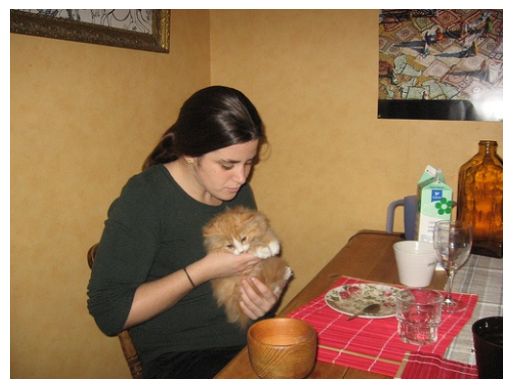

In [4]:
idx = 74
base_dir = './data/VOCdevkit/VOC2012/JPEGImages/'
filepath = os.path.join(base_dir, sorted(os.listdir(base_dir))[idx])
img = cv2.imread(filepath)
img = img[:, :, ::-1]
img = imutils.resize(img, width=512)

plt.imshow(img)
plt.axis('off')
plt.show()

## Predikció

In [5]:
task = "panoptic" #@param
out = None

visualizer = Visualizer(img, metadata=metadata, instance_mode=ColorMode.IMAGE)
predictions = predictor(img, "panoptic")
panoptic_seg, segments_info = predictions["panoptic_seg"]
out = visualizer.draw_panoptic_seg_predictions(
    panoptic_seg.to(cpu_device), segments_info, alpha=0.5
)
out = out.get_image()

## Eredmények

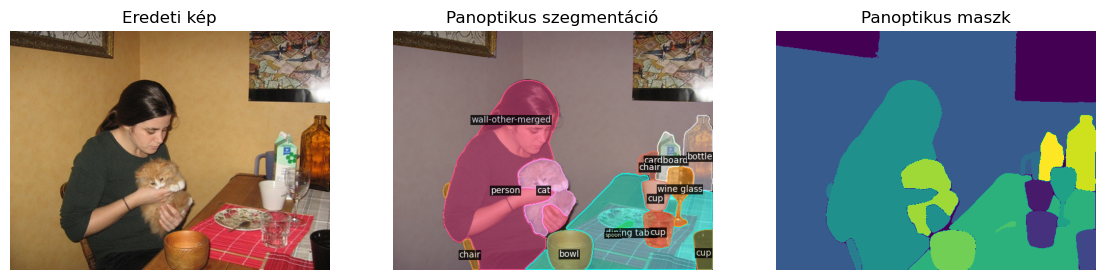

In [8]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(14, 7))
ax1.imshow(img)
ax1.set_title('Eredeti kép')
ax1.axis('off')
ax2.imshow(out)
ax2.set_title('Panoptikus szegmentáció')
ax2.axis('off')
ax3.imshow(panoptic_seg)
ax3.set_title('Panoptikus maszk')
ax3.axis('off')
plt.show()

---
# Testpózfelismerés: Detectron2
Telepítés és infók: https://github.com/facebookresearch/detectron2
## Kép betöltése

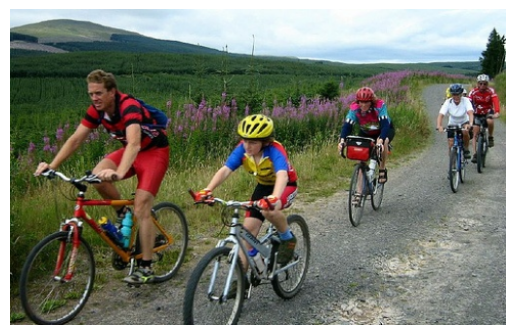

In [16]:
idx = 81
base_dir = './data/VOCdevkit/VOC2012/JPEGImages/'
filepath = os.path.join(base_dir, sorted(os.listdir(base_dir))[idx])
img = cv2.imread(filepath)
img = img[:, :, ::-1]
img = imutils.resize(img, width=512)

plt.imshow(img)
plt.axis('off')
plt.show()

## Modell betöltése

In [17]:
# Initialize Detectron2
cfg = get_cfg()
cfg.MODEL.DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
cfg.MODEL.DEVICE_ID = 0 if torch.cuda.is_available() else -1
cfg.merge_from_file(model_zoo.get_config_file("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml"))
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5  # Adjust the threshold as needed
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x.yaml")
predictor = DetectronDefaultPredictor(cfg)

[11/21 20:55:32 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from https://dl.fbaipublicfiles.com/detectron2/COCO-Keypoints/keypoint_rcnn_R_50_FPN_3x/137849621/model_final_a6e10b.pkl ...


## Predikció

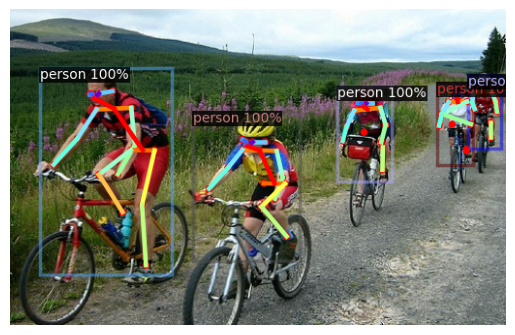

In [18]:
detectron_out = predictor(img)
# Visualize pose predictions
v = DetectronVisualizer(img, MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.0)
v = v.draw_instance_predictions(detectron_out["instances"].to("cpu"))
detectron_v_image = v.get_image()

plt.imshow(detectron_v_image)
plt.axis('off')
plt.show()

### Az első egyed kulcspontjainak koordinátái

In [21]:
detectron_out['instances'][0].pred_keypoints

tensor([[[2.4567e+02, 1.4155e+02, 1.1580e+00],
         [2.5056e+02, 1.3706e+02, 6.7647e-01],
         [2.4282e+02, 1.3625e+02, 1.0179e+00],
         [2.6318e+02, 1.3706e+02, 3.2038e-01],
         [2.3997e+02, 1.3462e+02, 2.4910e-01],
         [2.7539e+02, 1.4644e+02, 2.0619e-01],
         [2.3997e+02, 1.4521e+02, 1.8573e-01],
         [2.8150e+02, 1.7374e+02, 7.3904e-01],
         [2.2491e+02, 1.6396e+02, 3.4120e-01],
         [2.7376e+02, 1.9574e+02, 7.7775e-01],
         [2.0536e+02, 1.8555e+02, 4.8344e-01],
         [2.8394e+02, 1.8026e+02, 1.4308e-01],
         [2.6195e+02, 1.7985e+02, 3.4599e-01],
         [2.5951e+02, 2.0389e+02, 1.0920e-01],
         [2.5178e+02, 2.0756e+02, 3.0765e-02],
         [2.8557e+02, 2.3445e+02, 3.9701e-01],
         [2.4974e+02, 2.5360e+02, 4.0672e-02]]])

### Kereteződobozok koordinátái

In [24]:
for i in range(len(detectron_out['instances'])):
    print(detectron_out['instances'][i].pred_boxes)

Boxes(tensor([[188.8764, 105.8915, 299.2060, 259.5116]]))
Boxes(tensor([[ 30.9043,  60.9902, 166.5774, 274.1091]]))
Boxes(tensor([[338.4044,  79.6822, 394.3921, 177.8267]]))
Boxes(tensor([[441.0872,  76.3106, 478.4612, 161.4150]]))
Boxes(tensor([[472.9294,  67.8611, 506.6542, 143.9334]]))


---
# Arcfelismerés: FaceNet
Telepítés és infók: https://github.com/timesler/facenet-pytorch
## Könyvtárak betöltése

In [30]:
from facenet_pytorch import MTCNN
from facenet_pytorch import InceptionResnetV1
from PIL import Image, ImageDraw

## Kép betöltése

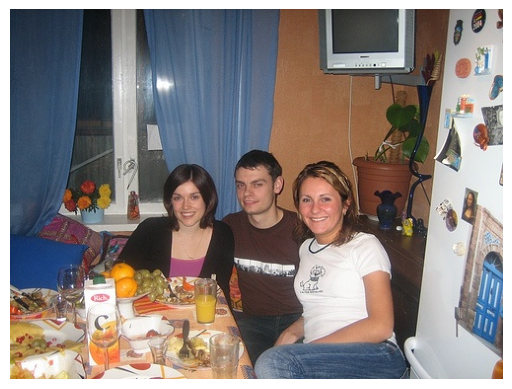

In [37]:
idx = 90
base_dir = './data/VOCdevkit/VOC2012/JPEGImages/'
filepath = os.path.join(base_dir, sorted(os.listdir(base_dir))[idx])

# Load your image
image = Image.open(filepath)

plt.imshow(image)
plt.axis('off')
plt.show()

## Predikció és vizualizáció

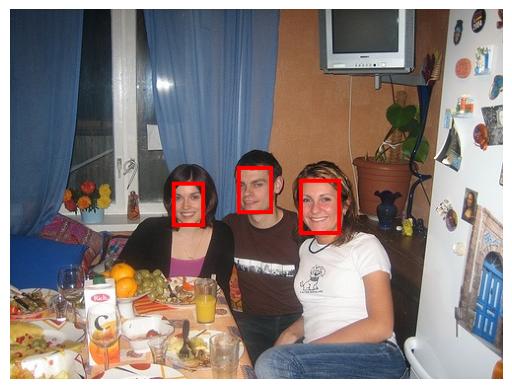

In [38]:
# Initialize MTCNN
mtcnn = MTCNN(keep_all=True)

# Detect faces and bounding boxes
boxes, _ = mtcnn.detect(image)

# Draw bounding boxes
draw = ImageDraw.Draw(image)
for box in boxes:
    draw.rectangle(box.tolist(), outline=(255, 0, 0), width=4)

# Display the image with bounding boxes
plt.imshow(image)
plt.axis('off')
plt.show()


## Beágyazóvektorok kivonatolása

In [36]:
resnet = InceptionResnetV1(pretrained='vggface2').eval()  # Use .eval() to set dropout and batch normalization layers to evaluation mode

# Extract faces and their embeddings
embeddings = []
for box in boxes:
    face = image.crop(box)
    face_tensor = mtcnn(face).unsqueeze(0)  # Transform face to tensor and add batch dimension

    # Get embedding
    with torch.no_grad():
        embedding = resnet(face_tensor[0, :, :, :])
        embeddings.append(embedding)

print(f'Beágyazóvektor mérete: {embeddings[0].shape}\n')
print(embeddings[0])

Beágyazóvektor mérete: torch.Size([1, 512])

tensor([[-0.0651,  0.0303, -0.0030,  0.0216,  0.0263, -0.0106, -0.0103,  0.0497,
          0.0076,  0.0104, -0.0184,  0.0673, -0.0609, -0.0078,  0.0489,  0.0392,
         -0.0206, -0.0417, -0.0026, -0.0450, -0.0117,  0.0710,  0.0144, -0.0075,
          0.0136,  0.0349,  0.1127,  0.0031,  0.0342,  0.0325, -0.0276, -0.0082,
          0.0614,  0.0022, -0.0062,  0.0656,  0.0354,  0.0770,  0.0268, -0.0419,
          0.0137, -0.0662,  0.0101, -0.0532, -0.0070, -0.0835, -0.0375, -0.0611,
          0.0115,  0.0695,  0.0406,  0.0441, -0.0071, -0.0648, -0.0723, -0.0121,
         -0.0362,  0.0645, -0.0379,  0.0356,  0.0217, -0.0671,  0.0174,  0.0032,
         -0.0015, -0.0032, -0.0398,  0.0212,  0.0235, -0.0022,  0.0084,  0.0010,
          0.0423, -0.0422,  0.0258,  0.0612,  0.0173, -0.0177, -0.0237,  0.0316,
          0.0058, -0.0519,  0.0574, -0.1275,  0.0285, -0.0457, -0.0379,  0.0373,
          0.0228,  0.0267, -0.0340, -0.0087, -0.0320,  0.0037, -

---
# Monokuláris inverz mélység érzékelés: MiDaS
Telepítés és infók: https://github.com/isl-org/MiDaS
## Kép betöltése

(373, 500, 3)


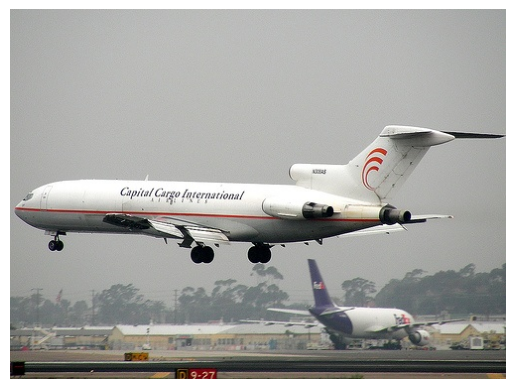

In [116]:
idx = 151  # 138
base_dir = './data/VOCdevkit/VOC2012/JPEGImages/'
filepath = os.path.join(base_dir, sorted(os.listdir(base_dir))[idx])

# Load your image
image = cv2.imread(filepath)
image = image[:, :, ::-1]

print(image.shape)

plt.imshow(image)
plt.axis('off')
plt.show()

## Modell betöltése

In [84]:
# Set up Midas for inverse monocular depth estimation
model_type = 'DPT_Large'  # Options from highest to lowest accuracy: DPT__Large, DPT_Hybrid, MiDaS_small
midas = torch.hub.load('intel-isl/MiDaS', model_type)
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
midas.to(device)
midas.eval()
midas_transforms = torch.hub.load('intel-isl/MiDaS', 'transforms')
transform = midas_transforms.dpt_transform if 'DPT' in model_type else midas_transforms.small_transform

Using cache found in /home/daniel/.cache/torch/hub/intel-isl_MiDaS_master
Using cache found in /home/daniel/.cache/torch/hub/intel-isl_MiDaS_master


## Predikció

(373, 500)


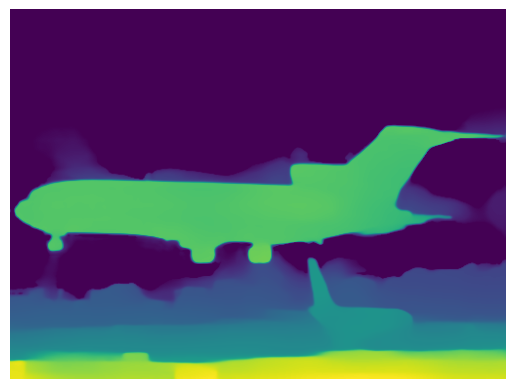

In [119]:
input_batch = transform(image).to(device)

# Use MiDaS to find the disparity map
with torch.no_grad():
    prediction = midas(input_batch)
    prediction = torch.nn.functional.interpolate(
        prediction.unsqueeze(1), 
        size = image.shape[:2], 
        mode = 'bilinear', 
        align_corners = False,
    ).squeeze()

midas_output = prediction.cpu().numpy()  # Transform the output to a cpu numpy array
disparity_image = midas_output.astype(np.float32) / 16.0  # Convert the disparity image to a 32-bit floating-point image

print(disparity_image.shape)

plt.imshow(disparity_image)
plt.axis('off')
plt.show()

## 3D rekonstrukció

In [120]:
# 3D reconstruction
baseline = 10
focal_length = 800

Q = np.float32([[1, 0, 0, -baseline], 
                [0, 1, 0, 0], 
                [0, 0, 0, focal_length], 
                [0, 0, -1.0 / baseline, 0]])

points_3D = cv2.reprojectImageTo3D(disparity_image, Q)  # Find the 3D reconstruction of the points based on disparity estiamtion

## 3D output
### PLY fájlformátum fejléce

In [121]:
def ply_header(n_vertex):
    return """ply
format ascii 1.0
element vertex {}
property float x
property float y
property float z
property uchar red
property uchar green
property uchar blue
end_header
""".format(n_vertex)

In [122]:
disparity_image.shape

(373, 500)

In [128]:
ply_path = './output.ply'
n_vertex =  0
content = ""

    
for i in range(disparity_image.shape[0]):
    for j in range(disparity_image.shape[1]):
        if not np.isnan(points_3D[i, j, :]).any() and not np.isinf(points_3D[i, j, :]).any():
            n_vertex += 1   
            content += f'{points_3D[i, j, 0]} {points_3D[i, j, 1]} {points_3D[i, j, 2]} {image[i, j, 0]} {image[i, j, 1]} {image[i, j, 2]}\n'

with open(ply_path, 'w') as out:
    out.write(ply_header(n_vertex=n_vertex))
    out.write(content)